In [1]:
# === Cell 0 — Setup & paths for comparison (respLM vs respLMS) ===
from pathlib import Path
import json, os, numpy as np, pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
import matplotlib.pyplot as plt

# --- Folders you gave me (each contains val_metrics.json, test_metrics.json, siamese_mlp_best.pt)
DIR_LM  = Path("/Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLM")
DIR_LMS = Path("/Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLMS")

# --- Dataset roots (same as training)
CSV_PATH = Path("/Users/kate/Documents/retina-model/2025-11-13_pilot_patch/manifests/trials.csv")
RUN_DIR  = Path("/Users/kate/Documents/retina-model/20251113_runAllImages")

# --- Model architecture knobs (must match training)
ENC_HIDDEN = [128, 64, 32]
USE_COMPARATOR = False   # your runs used the distance-diff head (no comparator)

# --- Response keys to compare
KEY_LM  = "respLM"
KEY_LMS = "respLMS"

# --- Misc
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 1234
torch.manual_seed(SEED); np.random.seed(SEED)

# Light checks
for d in [DIR_LM, DIR_LMS]:
    assert d.exists(), f"Missing folder: {d}"
assert CSV_PATH.exists(), "CSV not found"
assert RUN_DIR.exists(),  "run_dir not found"

print("Comparison setup OK.")
print("respLM dir :", DIR_LM)
print("respLMS dir:", DIR_LMS)
print("CSV        :", CSV_PATH)
print("run_dir    :", RUN_DIR)
print("Device     :", DEVICE.type)


Comparison setup OK.
respLM dir : /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLM
respLMS dir: /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/checkpoints_respLMS
CSV        : /Users/kate/Documents/retina-model/2025-11-13_pilot_patch/manifests/trials.csv
run_dir    : /Users/kate/Documents/retina-model/20251113_runAllImages
Device     : cpu


,split,acc_respLM,acc_respLMS,loss_respLM,loss_respLMS
0,train,NaN,NaN,NaN,NaN
1,val,0.96,1.0,0.083292,0.000007
2,test,0.96,1.0,0.135327,0.017243


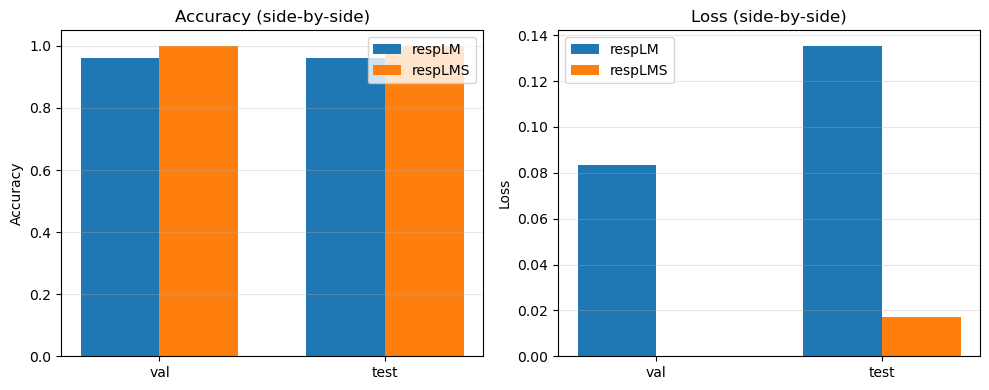

In [2]:
# === Cell 1 — Load saved metrics & draw side-by-side bars (val/test) ===
def load_metrics(dir_path: Path):
    out = {}
    for split in ("val", "test", "train"):
        fp = dir_path / f"{split}_metrics.json"
        if fp.exists():
            with open(fp, "r") as f:
                out[split] = json.load(f)
    return out

M_LM  = load_metrics(DIR_LM)
M_LMS = load_metrics(DIR_LMS)

def _get(m, split, key, default=np.nan):
    return float(m.get(split, {}).get(key, default))

rows = []
for split in ("train","val","test"):
    rows.append({
        "split": split,
        "acc_respLM":  _get(M_LM,  split, "acc"),
        "acc_respLMS": _get(M_LMS, split, "acc"),
        "loss_respLM": _get(M_LM,  split, "loss"),
        "loss_respLMS":_get(M_LMS, split, "loss"),
    })
dfm = pd.DataFrame(rows)
display(dfm)

# --- Simple side-by-side bars (val/test usually available)
def bar_pair(ax, xlabels, y1, y2, title, ylabel):
    x = np.arange(len(xlabels))
    w = 0.35
    ax.bar(x - w/2, y1, width=w, label="respLM")
    ax.bar(x + w/2, y2, width=w, label="respLMS")
    ax.set_xticks(x); ax.set_xticklabels(xlabels)
    ax.set_ylabel(ylabel); ax.set_title(title)
    ax.legend(); ax.grid(axis='y', alpha=0.3)

splits_to_plot = [s for s in ("val","test") if s in dfm["split"].values]
fig, axs = plt.subplots(1, 2, figsize=(10,4))
bar_pair(axs[0],
         splits_to_plot,
         [dfm.loc[dfm.split==s,"acc_respLM"].values[0] for s in splits_to_plot],
         [dfm.loc[dfm.split==s,"acc_respLMS"].values[0] for s in splits_to_plot],
         "Accuracy (side-by-side)", "Accuracy")

bar_pair(axs[1],
         splits_to_plot,
         [dfm.loc[dfm.split==s,"loss_respLM"].values[0] for s in splits_to_plot],
         [dfm.loc[dfm.split==s,"loss_respLMS"].values[0] for s in splits_to_plot],
         "Loss (side-by-side)", "Loss")
plt.tight_layout(); plt.show()


In [3]:
# === Cell 2 — Minimal dataset (parametric response_key) & loader for TEST split ===
class MRGCTripletsMat(Dataset):
    """
    Loads (anchor=initial, candT=true, candF=impostor) response vectors from .mat files.
    Uses 'response_key' in each .mat ('respLM' or 'respLMS').
    """
    def __init__(self, csv_path: Path, run_dir: Path, split: str, response_key: str, randomize: bool=False):
        self.df = (pd.read_csv(csv_path)
                   .query("split == @split")
                   .sort_values("trial_id")
                   .reset_index(drop=True))
        self.run_dir = Path(run_dir)
        self.key = response_key
        self.randomize = bool(randomize)  # keep False for fair, identical ordering

        self.mats = []
        for _, r in self.df.iterrows():
            tid = int(r["trial_id"])
            def _f(stem):
                name = f"mRGCresp_trial_{tid:06d}_{stem}_XYZ_dt10ms_T10.mat"
                return self.run_dir / split / name
            self.mats.append((_f("initial"), _f("candT"), _f("candF")))

        # Dimension probe
        v0 = self._load(self.mats[0][0])
        self.D = v0.shape[0]

    def _load(self, p: Path):
        d = loadmat(p, squeeze_me=True)
        if self.key not in d:
            raise KeyError(f"{self.key} not in {p.name} (keys: {list(d.keys())})")
        v = np.ravel(np.asarray(d[self.key])).astype(np.float32)
        if not np.isfinite(v).all():
            raise ValueError(f"Non-finite values in {p.name}")
        return v

    def __len__(self): return len(self.mats)

    def __getitem__(self, idx):
        pA, pT, pF = self.mats[idx]
        a = self._load(pA); t = self._load(pT); f = self._load(pF)
        label = 1.0
        if self.randomize and np.random.rand() < 0.5:
            t, f = f, t
            label = 0.0
        return {
            "anchor": torch.from_numpy(a),
            "candT":  torch.from_numpy(t),
            "candF":  torch.from_numpy(f),
            "label":  torch.tensor(label, dtype=torch.float32),
            "trial_id": int(self.df.iloc[idx]["trial_id"]),
        }

# Build identical TEST loaders (no randomization; same order)
test_LM  = MRGCTripletsMat(CSV_PATH, RUN_DIR, "test", KEY_LM,  randomize=False)
test_LMS = MRGCTripletsMat(CSV_PATH, RUN_DIR, "test", KEY_LMS, randomize=False)

loader_LM  = DataLoader(test_LM,  batch_size=32, shuffle=False)
loader_LMS = DataLoader(test_LMS, batch_size=32, shuffle=False)

print(f"TEST size: {len(test_LM)} trials | D={test_LM.D} (LM) / {test_LMS.D} (LMS)")


TEST size: 50 trials | D=10371 (LM) / 10371 (LMS)


In [4]:
# === Cell 3 — Rebuild the model & load best checkpoints from both folders ===
import torch.nn as nn

def mlp(in_dim, hidden):
    layers, dims = [], [in_dim] + list(hidden)
    for i in range(len(dims)-1):
        layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU(inplace=True)]
    return nn.Sequential(*layers)

class SharedEncoder(nn.Module):
    def __init__(self, in_dim, hidden):
        super().__init__()
        self.net = mlp(in_dim, hidden)
        self.out_dim = hidden[-1]
    def forward(self, x): return self.net(x)

class ComparatorHead(nn.Module):
    def __init__(self, emb_dim, use_products=False):
        super().__init__()
        feat_dim = (2 * emb_dim) if not use_products else (4 * emb_dim)
        self.use_products = use_products
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 64), nn.ReLU(inplace=True),
            nn.Linear(64, 16), nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )
    def forward(self, zA, zT, zF):
        feats = [torch.abs(zA - zT), torch.abs(zA - zF)]
        if self.use_products:
            feats += [zA * zT, zA * zF]
        return self.head(torch.cat(feats, dim=1)).squeeze(1)

class SiameseModel(nn.Module):
    def __init__(self, in_dim, enc_hidden, use_comparator=False, use_products=False):
        super().__init__()
        self.encoder = SharedEncoder(in_dim, enc_hidden)
        self.use_comparator = bool(use_comparator)
        if self.use_comparator:
            self.comparator = ComparatorHead(self.encoder.out_dim, use_products)
        else:
            self.register_buffer("one", torch.tensor(1.0))
    def forward(self, a, t, f):
        zA = self.encoder(a.float())
        zT = self.encoder(t.float())
        zF = self.encoder(f.float())
        if self.use_comparator:
            return self.comparator(zA, zT, zF)              # learned logit
        dT = torch.linalg.vector_norm(zA - zT, dim=1)       # no-comparator: margin
        dF = torch.linalg.vector_norm(zA - zF, dim=1)
        return (dF - dT) * self.one                         # positive ⇒ T closer

def load_model(ckpt_dir: Path, D_in: int):
    model = SiameseModel(D_in, ENC_HIDDEN, use_comparator=USE_COMPARATOR, use_products=False).to(DEVICE)
    ckpt = ckpt_dir / "siamese_mlp_best.pt"
    assert ckpt.exists(), f"Missing checkpoint: {ckpt}"
    state = torch.load(ckpt, map_location=DEVICE)
    model.load_state_dict(state, strict=True)
    model.eval()
    return model

model_LM  = load_model(DIR_LM,  test_LM.D)
model_LMS = load_model(DIR_LMS, test_LMS.D)
print("Models loaded.")


Models loaded.


Test acc — respLM:  0.960
Test acc — respLMS: 1.000
Prediction flips between models: 2/50 (4.0%)


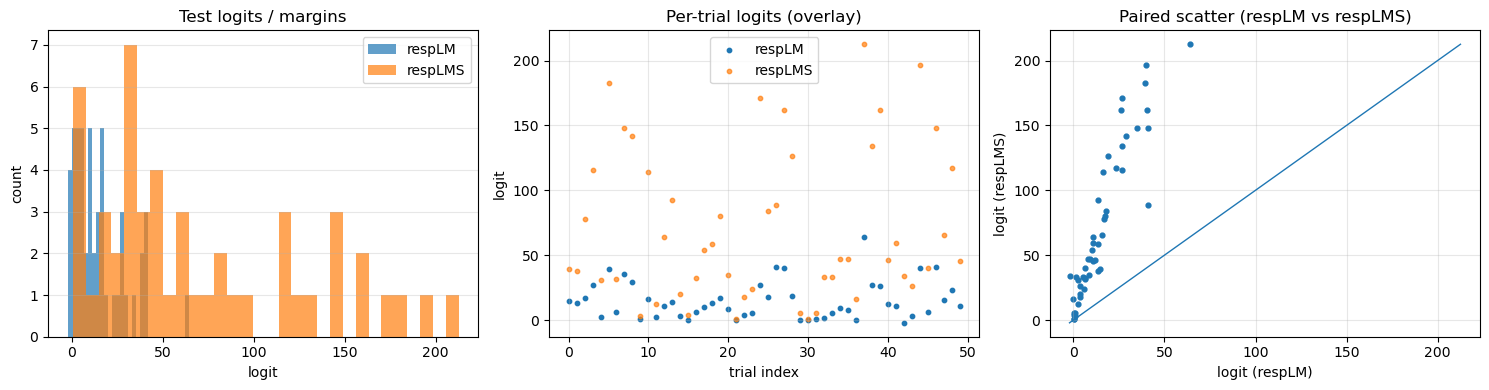

First 10 flipped trial_ids: [37, 43]


In [5]:
# === Cell 4 — Compute logits/margins on the SAME test trials; plot & flip stats ===
@torch.no_grad()
def collect_logits(model, loader):
    logits, labels, tids = [], [], []
    for b in loader:
        a = b["anchor"].to(DEVICE)
        t = b["candT"].to(DEVICE)
        f = b["candF"].to(DEVICE)
        y = b["label"].to(DEVICE)
        s = model(a, t, f)
        logits.append(s.cpu()); labels.append(y.cpu()); tids += b["trial_id"]
    return torch.cat(logits).numpy(), torch.cat(labels).numpy(), np.array(tids, int)

logits_LM,  labels, TIDS = collect_logits(model_LM,  loader_LM)
logits_LMS, labels2, _   = collect_logits(model_LMS, loader_LMS)
assert np.allclose(labels, labels2), "Labels/order mismatch across loaders."

# Predictions & flips
pred_LM  = (1/(1+np.exp(-logits_LM))  >= 0.5).astype(int)
pred_LMS = (1/(1+np.exp(-logits_LMS)) >= 0.5).astype(int)
flips = (pred_LM != pred_LMS)
n_flips = int(flips.sum())

# Quick accuracies (with your current labeling)
acc_LM  = float((pred_LM  == labels).mean())
acc_LMS = float((pred_LMS == labels).mean())

print(f"Test acc — respLM:  {acc_LM:.3f}")
print(f"Test acc — respLMS: {acc_LMS:.3f}")
print(f"Prediction flips between models: {n_flips}/{len(TIDS)} "
      f"({100.0*n_flips/len(TIDS):.1f}%)")

# --- Plots: histograms of logits (margins) & paired scatter
fig, axs = plt.subplots(1, 3, figsize=(15,4))

axs[0].hist(logits_LM, bins=30, alpha=0.7, label="respLM")
axs[0].hist(logits_LMS, bins=30, alpha=0.7, label="respLMS")
axs[0].set_title("Test logits / margins"); axs[0].set_xlabel("logit"); axs[0].set_ylabel("count")
axs[0].legend(); axs[0].grid(axis='y', alpha=0.3)

axs[1].scatter(range(len(TIDS)), logits_LM, s=10, label="respLM")
axs[1].scatter(range(len(TIDS)), logits_LMS, s=10, label="respLMS", alpha=0.7)
axs[1].set_title("Per-trial logits (overlay)"); axs[1].set_xlabel("trial index"); axs[1].set_ylabel("logit")
axs[1].legend(); axs[1].grid(alpha=0.3)

axs[2].scatter(logits_LM, logits_LMS, s=12)
mn = float(np.nanmin([logits_LM.min(), logits_LMS.min()]))
mx = float(np.nanmax([logits_LM.max(), logits_LMS.max()]))
axs[2].plot([mn,mx],[mn,mx], lw=1)
axs[2].set_title("Paired scatter (respLM vs respLMS)")
axs[2].set_xlabel("logit (respLM)"); axs[2].set_ylabel("logit (respLMS)")
axs[2].grid(alpha=0.3)

plt.tight_layout(); plt.show()

# List a few flipped trials
if n_flips:
    flipped_ids = TIDS[flips]
    print("First 10 flipped trial_ids:", flipped_ids[:10].tolist())
